Binary class distribution: Counter({1: 4651, 0: 231})
Balanced training distribution: Counter({0: 3720, 1: 3720})

===== Running Gradient Boosting K-Fold =====


/var/folders/pz/p1hrncws1n5gsmzgxczt0rpm0000gn/T/ipykernel_9462/3062954489.py:54: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_train = df_train.groupby("Engagement", group_keys=False).apply(



----- Fold 1 Report -----
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       744
           1       1.00      0.98      0.99       744

    accuracy                           0.99      1488
   macro avg       0.99      0.99      0.99      1488
weighted avg       0.99      0.99      0.99      1488

[[744   0]
 [ 15 729]]

----- Fold 2 Report -----
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       744
           1       1.00      0.99      0.99       744

    accuracy                           0.99      1488
   macro avg       0.99      0.99      0.99      1488
weighted avg       0.99      0.99      0.99      1488

[[744   0]
 [ 11 733]]

----- Fold 3 Report -----
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       744
           1       1.00      0.99      1.00       744

    accuracy                           1.00      1488
 

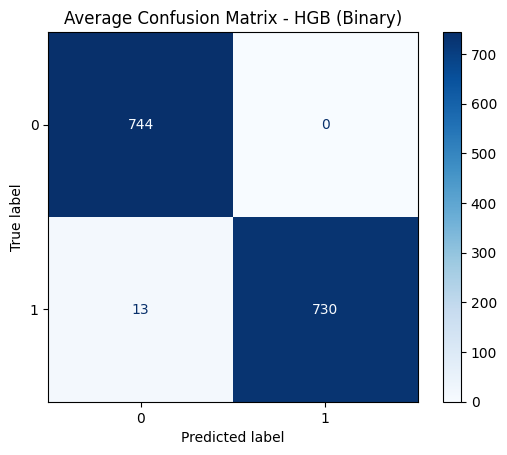


===== K-FOLD AVERAGE METRICS =====
Avg Accuracy  : 0.991
Avg Precision : 1.000
Avg Recall    : 0.982
Avg F1 Score  : 0.991

===== VALIDATION SET PERFORMANCE (Binary) =====
              precision    recall  f1-score   support

           0       0.25      0.22      0.23        23
           1       0.96      0.97      0.96       465

    accuracy                           0.93       488
   macro avg       0.61      0.59      0.60       488
weighted avg       0.93      0.93      0.93       488

[[  5  18]
 [ 15 450]]


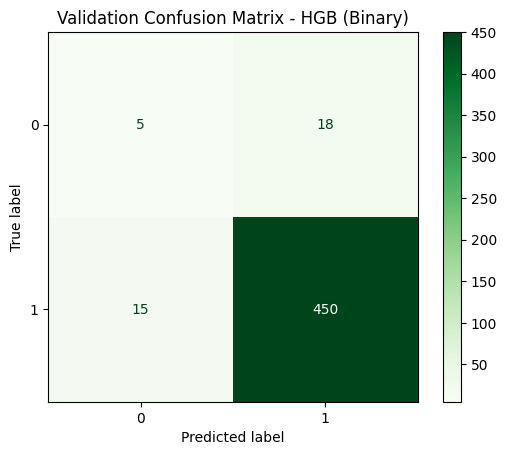

In [2]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# --- Load dataset ---
data = pd.read_csv("/Users/khushnumaparveen/Downloads/merged_results.csv")

# --- Select features ---
au_cols = [col for col in data.columns if col.startswith("au")]
landmark_cols = [col for col in data.columns if col.startswith("x_") or col.startswith("y_")]
possible_pose_cols = ["pose_Rx", "pose_Ry", "pose_Rz", "pitch", "yaw", "roll"]
pose_cols = [col for col in possible_pose_cols if col in data.columns]

feature_cols = au_cols + landmark_cols + pose_cols
X = data[feature_cols].fillna(0)

# ------------------------------
# 0. CONVERT ENGAGEMENT TO BINARY (0–1)
# ------------------------------
# 0–1 = disengaged (0)
# 2–3 = engaged (1)
y = (data["Engagement"] >= 2).astype(int)

print("Binary class distribution:", Counter(y))

# ------------------------------
# 1. TRAIN / VALIDATION / TEST SPLIT  (80 / 10 / 10)
# ------------------------------
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

# ------------------------------
# 2. BALANCE ONLY THE TRAINING SET
# ------------------------------
df_train = pd.concat([X_train_full, y_train_full], axis=1)
max_size = df_train["Engagement"].value_counts().max()

balanced_train = df_train.groupby("Engagement", group_keys=False).apply(
    lambda x: x.sample(max_size, replace=True, random_state=42)
).reset_index(drop=True)

X_bal = balanced_train[feature_cols]
y_bal = balanced_train["Engagement"]

print("Balanced training distribution:", Counter(y_bal))

# ------------------------------
# 3. SCALE DATA
# ------------------------------
scaler = StandardScaler()
X_bal_scaled = scaler.fit_transform(X_bal)
X_val_scaled = scaler.transform(X_val)

# ------------------------------
# 4. STRATIFIED K-FOLD ON TRAIN
# ------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accs, precs, recs, f1s = [], [], [], []

all_conf_matrices = np.zeros((2, 2), dtype=int)

print("\n===== Running Gradient Boosting K-Fold =====")

for fold, (train_idx, test_idx) in enumerate(skf.split(X_bal_scaled, y_bal), 1):
    X_train, X_test_fold = X_bal_scaled[train_idx], X_bal_scaled[test_idx]
    y_train, y_test_fold = y_bal.iloc[train_idx], y_bal.iloc[test_idx]

    model = HistGradientBoostingClassifier(
        learning_rate=0.1,
        max_depth=10,
        max_leaf_nodes=63,
        min_samples_leaf=20,
        l2_regularization=0.0,
        class_weight="balanced",
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred_fold = model.predict(X_test_fold)

    accs.append(accuracy_score(y_test_fold, y_pred_fold))
    precs.append(precision_score(y_test_fold, y_pred_fold, zero_division=0))
    recs.append(recall_score(y_test_fold, y_pred_fold, zero_division=0))
    f1s.append(f1_score(y_test_fold, y_pred_fold, zero_division=0))

    cm = confusion_matrix(y_test_fold, y_pred_fold)
    all_conf_matrices += cm

    print(f"\n----- Fold {fold} Report -----")
    print(classification_report(y_test_fold, y_pred_fold))
    print(cm)

# ------------------------------
# 5. AVERAGE CONFUSION MATRIX
# ------------------------------
avg_cm = all_conf_matrices // 5
print("\n===== Average Confusion Matrix =====")
print(avg_cm)

disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm, display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title("Average Confusion Matrix - HGB (Binary)")
plt.show()

print("\n===== K-FOLD AVERAGE METRICS =====")
print(f"Avg Accuracy  : {np.mean(accs):.3f}")
print(f"Avg Precision : {np.mean(precs):.3f}")
print(f"Avg Recall    : {np.mean(recs):.3f}")
print(f"Avg F1 Score  : {np.mean(f1s):.3f}")

# ------------------------------
# 6. TRAIN FINAL MODEL
# ------------------------------
final_model = HistGradientBoostingClassifier(
    learning_rate=0.2,
    max_depth=10,
    max_leaf_nodes=127,
    min_samples_leaf=10,
    l2_regularization=0.0,
    class_weight="balanced",
    random_state=42 
)

final_model.fit(X_bal_scaled, y_bal)

# ------------------------------
# 7. VALIDATION PERFORMANCE
# ------------------------------
val_pred = final_model.predict(X_val_scaled)

print("\n===== VALIDATION SET PERFORMANCE (Binary) =====")
print(classification_report(y_val, val_pred))

val_cm = confusion_matrix(y_val, val_pred)
print(val_cm)

disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=[0,1])
disp.plot(cmap="Greens", values_format='d')
plt.title("Validation Confusion Matrix - HGB (Binary)")
plt.show()


In [22]:
# from sklearn.ensemble import HistGradientBoostingClassifier
# from sklearn.metrics import f1_score
# from sklearn.model_selection import StratifiedKFold
# import numpy as np

# # ------------------------------------
# # PARAMETER GRID
# # ------------------------------------
# learning_rates = [0.05, 0.1, 0.2]
# max_depths = [5, 8, 10]
# leaf_nodes = [31, 63, 127]
# min_samples_leafs = [10, 20, 30]
# l2_regs = [0.0, 0.1]

# # ------------------------------------
# # START TUNING
# # ------------------------------------
# best_score = -1
# best_params = None

# skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# print("\n===== Starting Hyperparameter Tuning Loop =====\n")

# for lr in learning_rates:
#     for depth in max_depths:
#         for leaves in leaf_nodes:
#             for msl in min_samples_leafs:
#                 for l2 in l2_regs:

#                     fold_scores = []

#                     for train_idx, test_idx in skf.split(X_bal_scaled, y_bal):
#                         X_tr, X_va = X_bal_scaled[train_idx], X_bal_scaled[test_idx]
#                         y_tr, y_va = y_bal.iloc[train_idx], y_bal.iloc[test_idx]

#                         model = HistGradientBoostingClassifier(
#                             learning_rate=lr,
#                             max_depth=depth,
#                             max_leaf_nodes=leaves,
#                             min_samples_leaf=msl,
#                             l2_regularization=l2,
#                             class_weight="balanced",
#                             random_state=42
#                         )

#                         model.fit(X_tr, y_tr)
#                         preds = model.predict(X_va)

#                         score = f1_score(y_va, preds, zero_division=0)
#                         fold_scores.append(score)

#                     avg_score = np.mean(fold_scores)

#                     print(f"Params: lr={lr}, depth={depth}, leaves={leaves}, "
#                           f"min_leaf={msl}, l2={l2}  --> F1={avg_score:.4f}")

#                     if avg_score > best_score:
#                         best_score = avg_score
#                         best_params = (lr, depth, leaves, msl, l2)

# print("\n=========== BEST PARAMETERS FOUND ===========")
# print("Best F1 Score:", best_score)
# print("Best Params:", best_params)



===== Starting Hyperparameter Tuning Loop =====

Params: lr=0.05, depth=5, leaves=31, min_leaf=10, l2=0.0  --> F1=0.9423
Params: lr=0.05, depth=5, leaves=31, min_leaf=10, l2=0.1  --> F1=0.9442
Params: lr=0.05, depth=5, leaves=31, min_leaf=20, l2=0.0  --> F1=0.9359
Params: lr=0.05, depth=5, leaves=31, min_leaf=20, l2=0.1  --> F1=0.9376
Params: lr=0.05, depth=5, leaves=31, min_leaf=30, l2=0.0  --> F1=0.9360
Params: lr=0.05, depth=5, leaves=31, min_leaf=30, l2=0.1  --> F1=0.9349
Params: lr=0.05, depth=5, leaves=63, min_leaf=10, l2=0.0  --> F1=0.9423
Params: lr=0.05, depth=5, leaves=63, min_leaf=10, l2=0.1  --> F1=0.9442
Params: lr=0.05, depth=5, leaves=63, min_leaf=20, l2=0.0  --> F1=0.9359
Params: lr=0.05, depth=5, leaves=63, min_leaf=20, l2=0.1  --> F1=0.9376
Params: lr=0.05, depth=5, leaves=63, min_leaf=30, l2=0.0  --> F1=0.9360
Params: lr=0.05, depth=5, leaves=63, min_leaf=30, l2=0.1  --> F1=0.9349
Params: lr=0.05, depth=5, leaves=127, min_leaf=10, l2=0.0  --> F1=0.9423
Params: lr=0.


===== TEST SET PERFORMANCE =====
              precision    recall  f1-score   support

           0       0.31      0.22      0.26        23
           1       0.96      0.98      0.97       466

    accuracy                           0.94       489
   macro avg       0.64      0.60      0.61       489
weighted avg       0.93      0.94      0.94       489

[[  5  18]
 [ 11 455]]


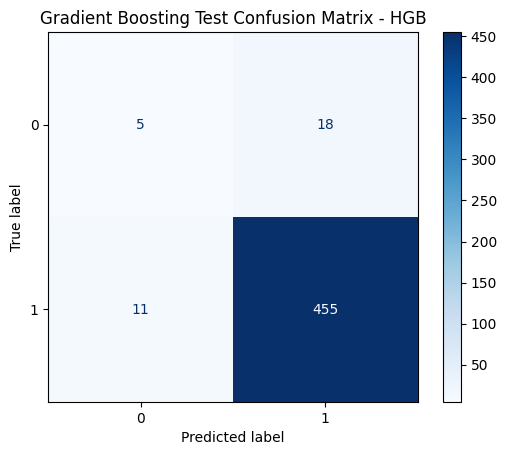

In [8]:
# ============================================
# 8. TEST SET EVALUATION (FINAL CHECK)
# ============================================

# Scale test features
X_test_scaled = scaler.transform(X_test)

# Predict
test_pred = final_model.predict(X_test_scaled)

print("\n===== TEST SET PERFORMANCE =====")
print(classification_report(y_test, test_pred))

test_cm = confusion_matrix(y_test, test_pred)
print(test_cm)

disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=sorted(y_bal.unique()))
disp.plot(cmap="Blues", values_format='d')
plt.title("Gradient Boosting Test Confusion Matrix - HGB")
plt.show()


In [4]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

def get_metrics_full(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)

    TN, FP = cm[0]
    FN, TP = cm[1]

    class0_accuracy = TN / (TN + FP) if (TN + FP) > 0 else 0
    class1_accuracy = TP / (TP + FN) if (TP + FN) > 0 else 0

    return {
        "Model": model_name,
        "Overall Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1 Score": f1_score(y_true, y_pred, zero_division=0),
        "Class 0 Accuracy": class0_accuracy,
        "Class 1 Accuracy": class1_accuracy
    }
get_metrics_full(y_test,test_pred,"Gradient Boosting")

NameError: name 'test_pred' is not defined

In [24]:
from sklearn.metrics import confusion_matrix

def accuracy_details(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()

    acc_class_0 = tn / (tn + fn + 1e-9)
    acc_class_1 = tp / (tp + fp + 1e-9)
    overall_acc = (tp + tn) / (tp + tn + fp + fn)

    print("Confusion Matrix:\n", cm)
    print(f"\nAccuracy Class 0 (Disengaged): {acc_class_0:.3f}")
    print(f"Accuracy Class 1 (Engaged)   : {acc_class_1:.3f}")
    print(f"Overall Accuracy             : {overall_acc:.3f}")

accuracy_details(y_test,test_pred)

Confusion Matrix:
 [[  7  16]
 [ 15 451]]

Accuracy Class 0 (Disengaged): 0.318
Accuracy Class 1 (Engaged)   : 0.966
Overall Accuracy             : 0.937
